In [1]:
!pip install --quiet git+https://github.com/simaki/deep-gamblers

You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from deep_gamblers import coverage, GamblerLoss

## Load

In [3]:
def normalize(x):
    return x / 255.0


def split_tr_va(a, p=0.2):
    n = a.shape[0]
    a_tr, a_va = a[: int(n * p)], a[int(n * p) :]
    return (a_tr, a_va)


def get_onehot(y):
    return np.eye(10)[y]


def add_newaxis(x):
    return x[..., np.newaxis]

In [4]:
from tensorflow.keras.datasets import mnist

(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr, x_te = normalize(x_tr), normalize(x_te)
x_tr, x_te = add_newaxis(x_tr), add_newaxis(x_te)
y_tr, y_te = get_onehot(y_tr), get_onehot(y_te)
x_tr, x_va = split_tr_va(x_tr)
y_tr, y_va = split_tr_va(y_tr)

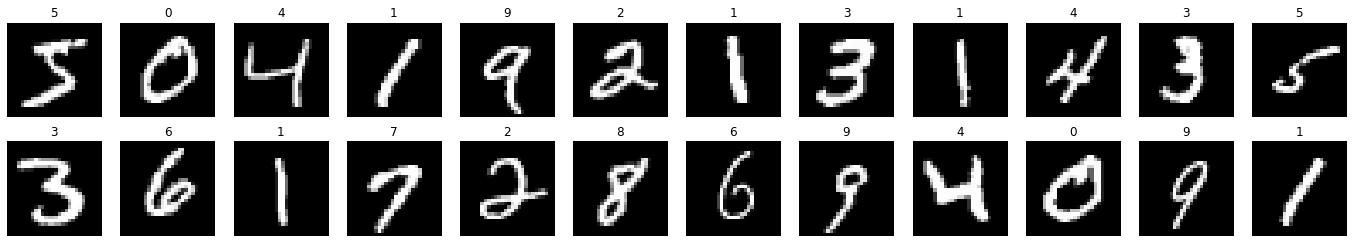

In [5]:
plt.figure(figsize=(24, 4))

h, w = 2, 12

for i in range(h * w):
    plt.subplot(h, w, i + 1)
    plt.imshow(x_tr[i, ..., 0], cmap="gray")
    plt.axis("off")
    plt.title(np.argmax(y_tr[i]))

plt.show()

## Predict

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential(
    [
        Conv2D(10, 4, activation="relu"),
        Conv2D(10, 4, activation="relu"),
        Conv2D(10, 4, activation="relu"),
        Conv2D(10, 4, activation="relu"),
        Flatten(),
        Dense(10 + 1, activation="softmax"),
    ]
)

In [8]:
model.compile(optimizer="adam", loss=GamblerLoss(10.0), metrics=[coverage, "accuracy"])
model.fit(x_tr, y_tr, epochs=1)

375/375 [==============================] - 12s 31ms/step - loss: 0.3540 - coverage: 1.0000 - accuracy: 0.8913


In [9]:
model.compile(optimizer="adam", loss=GamblerLoss(2.6), metrics=[coverage, "accuracy"])
model.fit(
    x_tr,
    y_tr,
    validation_data=(x_va, y_va),
    epochs=30,
    callbacks=[EarlyStopping(patience=2,),],
)
model.evaluate(x_te, y_te)

Epoch 1/30
375/375 [==============================] - 27s 72ms/step - loss: 0.1179 - coverage: 0.9988 - accuracy: 0.9640 - val_loss: 0.1296 - val_coverage: 0.9997 - val_accuracy: 0.9595
Epoch 2/30
375/375 [==============================] - 26s 69ms/step - loss: 0.0787 - coverage: 0.9959 - accuracy: 0.9718 - val_loss: 0.1040 - val_coverage: 0.9996 - val_accuracy: 0.9675
Epoch 3/30
375/375 [==============================] - 30s 80ms/step - loss: 0.0548 - coverage: 0.9970 - accuracy: 0.9804 - val_loss: 0.0950 - val_coverage: 0.9952 - val_accuracy: 0.9701
Epoch 4/30
375/375 [==============================] - 29s 77ms/step - loss: 0.0417 - coverage: 0.9962 - accuracy: 0.9837 - val_loss: 0.1105 - val_coverage: 0.9976 - val_accuracy: 0.9671
Epoch 5/30
313/313 [==============================] - 3s 8ms/step - loss: 0.1104 - coverage: 0.9981 - accuracy: 0.9717


[0.11035450547933578, 0.9981030225753784, 0.9717000126838684]

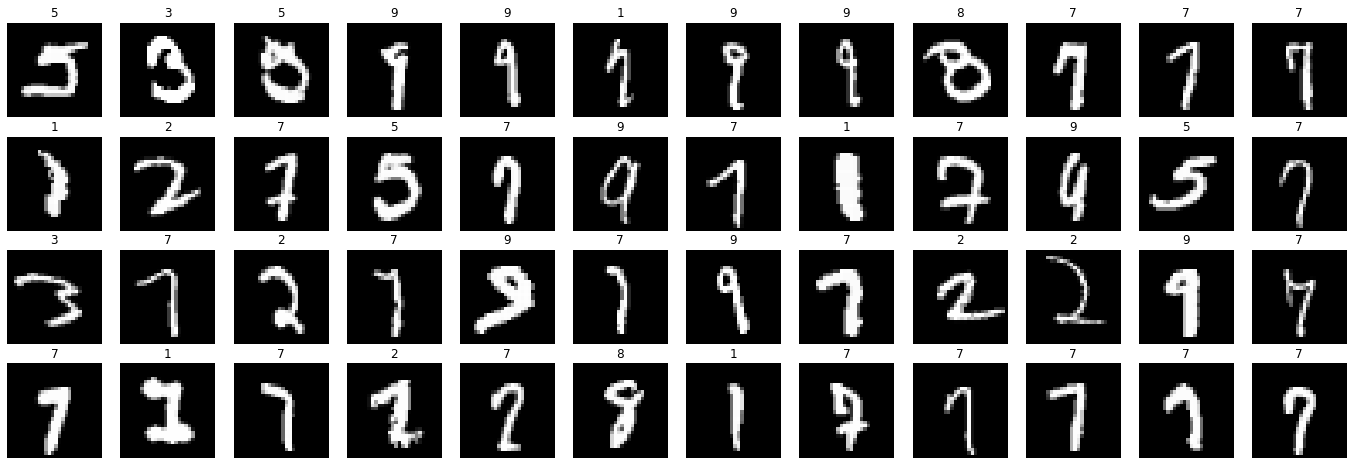

In [10]:
y_pr = model.predict(x_te)
i_top_reject = np.argsort(-y_pr[:, -1])
x_top_reject = x_te[i_top_reject]
y_top_reject = y_te[i_top_reject]

plt.figure(figsize=(24, 8))

h, w = 4, 12

for i in range(h * w):
    plt.subplot(h, w, i + 1)
    plt.imshow(x_top_reject[i, ..., 0], cmap="gray")
    plt.axis("off")
    plt.title(np.argmax(y_top_reject[i]))

plt.show()